# Related papers

[1] Zhi-Qin John Xu* , Yaoyu Zhang, and Yanyang Xiao, Training behavior of deep neural network in frequency domain, arXiv preprint: 1807.01251, (2018), 26th International Conference on Neural Information Processing (ICONIP 2019). [pdf](https://ins.sjtu.edu.cn/people/xuzhiqin/pub/training_behavior_ICONIP2019_XZX.pdf) and [web](https://link.springer.com/chapter/10.1007/978-3-030-36708-4_22)

[2] Zhi-Qin John Xu* , Yaoyu Zhang, Tao Luo, Yanyang Xiao, Zheng Ma, Frequency Principle: Fourier Analysis Sheds Light on Deep Neural Networks, arXiv preprint: 1901.06523, Communications in Computational Physics (CiCP). [pdf](https://ins.sjtu.edu.cn/people/xuzhiqin/pub/shedlightCiCP.pdf) and in [web](https://www.global-sci.org/intro/article_detail/cicp/18395.html), some code is in [github](https://github.com/xuzhiqin1990/F-Principle) 

[3] Zhi-Qin John Xu*, Yaoyu Zhang, Tao Luo, Overview frequency principle/spectral bias in deep learning. arxiv 2201.07395 (2022) . [pdf](https://ins.sjtu.edu.cn/people/xuzhiqin/pub/fpoverview2201.07395.pdf), and in [arxiv](https://arxiv.org/abs/2201.07395).

For more details, refer to [Zhi-Qin John Xu's homepage](https://ins.sjtu.edu.cn/people/xuzhiqin/pub.html)

# Frequency Principle (1D)

DNNs often fit target functions from low to high frequencies.  

The first figure shows the evolution of the function in spatial domain, the red line is the target function, and the blue line is the DNN output. *Ordinate vs. Abscissa : y vs. x*. 

The second figure shows the evolution of the function in Fourier domain, the red line is the FFT of the target function, and the blue line is the FFT of DNN output. *Ordinate vs. Abscissa: amplitude vs. frequency*. 

<!-- ![Title](https://ins.sjtu.edu.cn/people/xuzhiqin/index.html) -->
![value](./pic/value.gif)![freq](./pic/F-Principle_one_dim.gif)


## Which variables were not controlled in the experiment? 

Is it the frequency differences or amplitude differences between different frequencies that affect the fitting speed of the target function?


In [1]:
%%time
import os
import time
import warnings
import numpy as np
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from typing import List
import argparse
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re


CPU times: user 1.75 s, sys: 411 ms, total: 2.16 s
Wall time: 894 ms


#   Default configuration parameter settings.

`argparse` is a Python package that provides a convenient way to parse command line arguments. It allows us to define the arguments our program expects and will parse them for us. This makes it easy to write user-friendly command-line interfaces for our programs.

To use `argparse`, we first create an `ArgumentParser` object, which will hold all the information necessary to parse the command-line arguments. We then define the arguments we expect using the `add_argument` method. This method takes several parameters, such as the name of the argument, its type, and a help message.

In this code, we are using `argparse` to parse the command-line arguments that are passed to the program. We define several arguments, such as the learning rate, optimizer, and number of epochs, and then parse them using `args, _ = parser.parse_known_args()`. This allows us to easily customize the behavior of our program without having to modify the code itself.



In [7]:
parser = argparse.ArgumentParser(description='PyTorch Training for Frequency Principle')



parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
parser.add_argument('--optimizer', default='adam',
                    help='optimizer: sgd | adam')
parser.add_argument('--epochs', default=20000, type=int,
                    metavar='N', help='number of total epochs to run')
parser.add_argument('--batch_size',   default=101, type=int,
                    help='the batch size for model (default: 101)')
parser.add_argument('--training_size',   default=101, type=int,
                    help='the training data size for model (default: 101)')
parser.add_argument('--test_size',   default=1000, type=int,
                    help='the test data size for model (default: 1000)')
parser.add_argument('--t', type=float, default=0.5,
                    help='parameter initialization distribution variance power(We first assume that each layer is the same width.)')
parser.add_argument('--boundary', nargs='+', type=str, default=['-1', '1'],
                    help='the boundary of 1D data')
parser.add_argument('--act_func_name', default='learn_psi',
                    help='activation function: tanh | ReLU | Sigmoid | hat｜learn_psi')
parser.add_argument('--hidden_layers_width',
                    nargs='+', type=int, default=[200,200,200,100])
parser.add_argument('--input_dim',   default=1, type=int,
                    help='the input dimension for model (default: 1)')
parser.add_argument('--output_dim',   default=1, type=int,
                    help='the output dimension for model (default: 1)')
parser.add_argument('--device',   default='mps', type=str,
                    help='device used to train (cpu or cuda)')
parser.add_argument('--plot_epoch',   default=1000, type=int,
                    help='step size of plotting interval (default: 1000)')
parser.add_argument('--ini_path', type=str,
                    default='')

args, unknown = parser.parse_known_args()

print(args)

print(unknown)

Namespace(lr=0.0001, optimizer='adam', epochs=20000, batch_size=101, training_size=101, test_size=1000, t=0.5, boundary=['-1', '1'], act_func_name='learn_psi', hidden_layers_width=[200, 200, 200, 100], input_dim=1, output_dim=1, device='mps', plot_epoch=1000, ini_path='')
['-f', '/Users/liangaoming/Library/Jupyter/runtime/kernel-2d938c84-762b-464e-be2f-8edd0112e64b.json']




# Discrete Fourier Transform (DFT) and Inverse Transform

The **Discrete Fourier Transform (DFT)** is defined by: $$X_k = \sum_{n=0}^{N-1} x_n exp(-2\pi i k n/N); 0 \leq k \leq N-1.$$
And the **Inverse Discrete Fourier Transform (IDFT)** is defined by: $$x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k exp(2\pi i k n/N).$$ 

`SelectPeakIndex` is a function for selecting frequency peaks, which are used to compare the convergence rates of different frequencies. The reason for choosing the frequency peak is explained later.

In [8]:
def my_fft(data, freq_len=40, isnorm=1):

    """
    This function performs FFT on the given data.
    
    Args:
    data (numpy.ndarray): The input data.
    freq_len (int): The length of the frequency.
    isnorm (int): The normalization factor.
    
    Returns:
    return_fft (numpy.ndarray): The FFT output array.
    """

    # second_diff_input = np.mean(np.diff(np.diff(np.squeeze(x_input))))
    # if abs(second_diff_input) < 1e-10:
    datat = np.squeeze(data)
    datat_fft = np.fft.fft(datat)
    ind2 = range(freq_len)
    fft_coe = datat_fft[ind2]
    if isnorm == 1:
        return_fft = np.absolute(fft_coe)
    else:
        return_fft = fft_coe

    return return_fft

def SelectPeakIndex(FFT_Data, endpoint=True):

    """
    This function selects the peak index from FFT data.
    
    Args:
    FFT_Data (numpy.ndarray): The FFT data array.
    endpoint (bool): Whether to include endpoints or not. Default is True.
    
    Returns:
    sel_ind (numpy.ndarray): Selected index array with peaks. 
    """
    
    D1 = FFT_Data[1:-1]-FFT_Data[0:-2]
    D2 = FFT_Data[1:-1]-FFT_Data[2:]
    D3 = np.logical_and(D1 > 0, D2 > 0)
    tmp = np.where(D3 == True)
    sel_ind = tmp[0]+1
    if endpoint: #
        if FFT_Data[0]-FFT_Data[1] > 0:
            sel_ind = np.concatenate([[0], sel_ind])
        if FFT_Data[-1]-FFT_Data[-2] > 0:
            Last_ind = len(FFT_Data)-1
            sel_ind = np.concatenate([sel_ind, [Last_ind]])
    return sel_ind





# DFT and False Frequencies with Insufficient Sampling

### When the sampling rate is insufficient to satisfy the Nyquist criterion, aliasing can occur, leading to the appearance of false frequencies in the DFT.

The Nyquist criterion states that in order to accurately reconstruct a signal from its samples, the sampling rate must be at least twice the highest frequency component in the signal. If the sampling rate is insufficient, aliasing can occur, which means that high-frequency components in the signal can be incorrectly interpreted as low-frequency components. This can lead to the appearance of false frequencies in the DFT, which can make it difficult to accurately analyze the signal. To avoid aliasing, it is important to choose a sampling rate that satisfies the Nyquist criterion for the signal being analyzed.

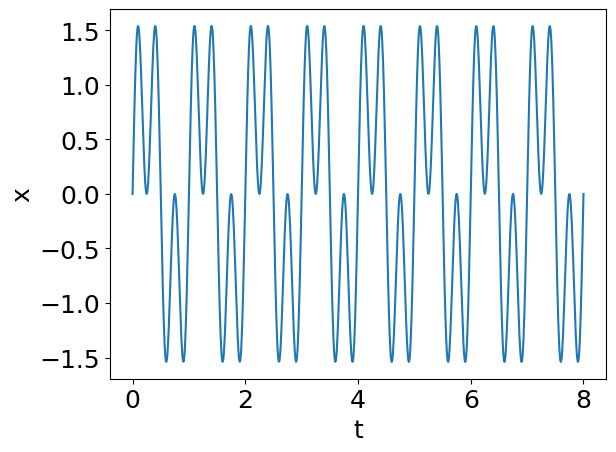

sample size=100: 


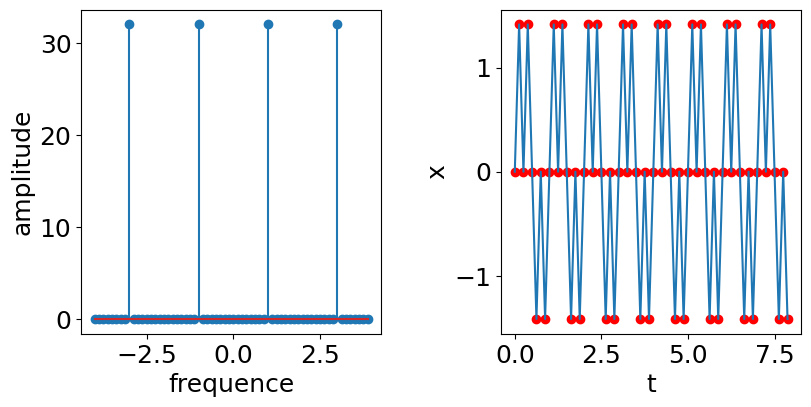

sample size=10: 


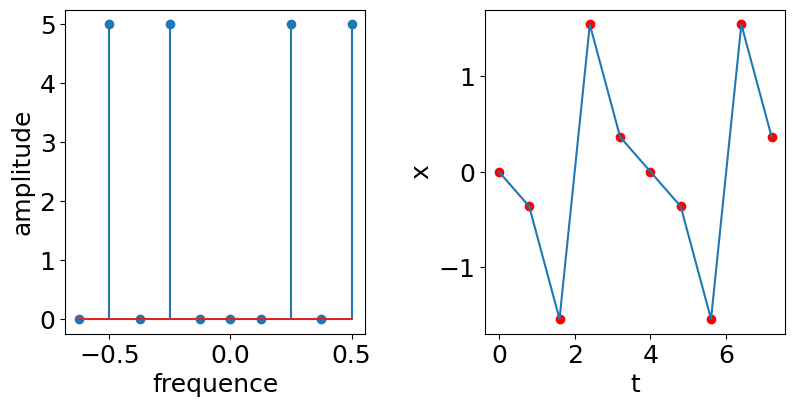

In [9]:
def dft_analysis(f, T, N):

    """
    Perform DFT analysis on a given function f with a total time of T and N samples.

    Args:
        f (function): The function to be analyzed.
        T (float): The total time of the signal.
        N (int): The number of samples.

    Returns:
        None
    """

    

    t = np.linspace(0, T, N, endpoint=False)
    x = f(t)
    X = np.fft.fft(x)

    freqs = np.fft.fftfreq(N, d=T/N)

    fig = plt.figure(figsize=(12.0, 5.4))
    axes = [fig.add_axes(
    [.1, .25, .25, .6]),fig.add_axes(
    [.45, .25, .25, .6])]
    axes[0].stem(freqs, np.abs(X))
    axes[0].set_xlabel('frequence', fontsize=18)
    axes[0].set_ylabel('amplitude', fontsize=18)
    axes[1].plot(t,x)
    axes[1].scatter(t,x, color='r')
    axes[1].set_xlabel('t', fontsize=18)
    axes[1].set_ylabel('x', fontsize=18)
    axes[0].tick_params(labelsize=18)
    axes[1].tick_params(labelsize=18)
    plt.show()
    plt.close()

def dft_target(f, T, N):

    """
    Perform DFT analysis on a given function f with a total time of T and N samples.

    Args:
        f (function): The function to be analyzed.
        T (float): The total time of the signal.
        N (int): The number of samples.

    Returns:
        None
    """



    t = np.linspace(0, T, N)
    x = f(t)
    
    plt.plot(t,x)
    plt.xlabel('t', fontsize=18)
    plt.ylabel('x', fontsize=18)

    plt.tick_params(labelsize=18)
    plt.show()
    plt.close()

def f(t): 
    return np.sin(2*np.pi*t) + np.sin(6*np.pi*t)

dft_target(f, 8, 1000)

print('sample size=100: ')
dft_analysis(f, 8, 64)
print('sample size=10: ')
dft_analysis(f, 8, 10)


# Spectral Leakage 

If the number of samples in a Discrete Fourier Transform (DFT) is not an integer multiple of the signal’s period, the transform may be affected. This phenomenon is known as **spectral leakage**, where the energy of the original signal is spread across multiple frequency components instead of being concentrated at a single frequency component. 

Aperiodic truncation makes the energy of the original signal spread across multiple frequency components, so we choose frequency peaks to avoid the effects of aperiodic truncation.

sample size=100: 


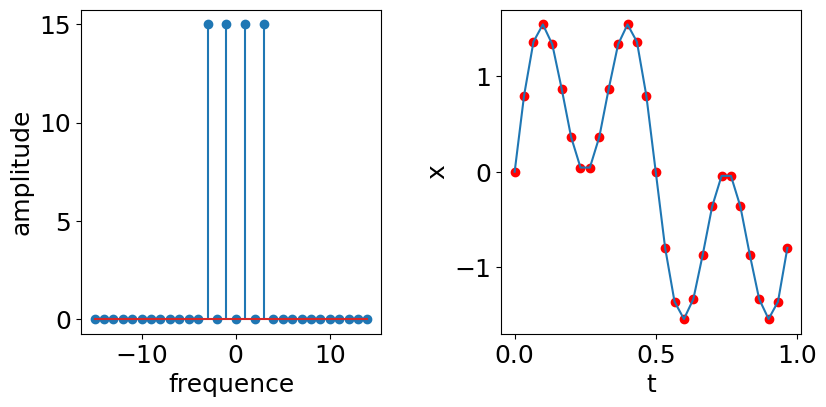

sample size=10: 


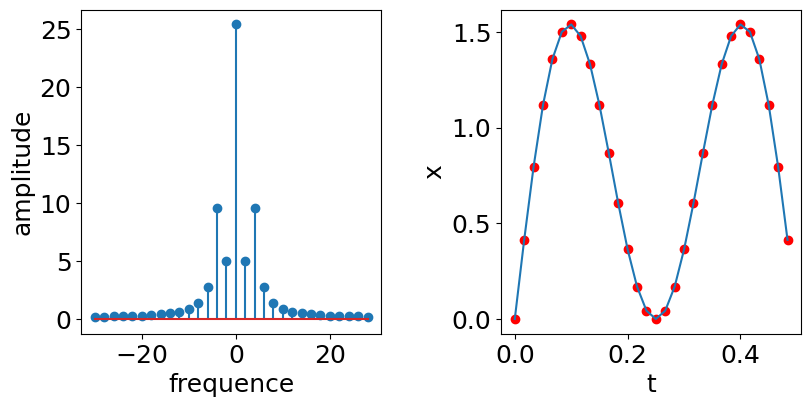

sample size=10: 


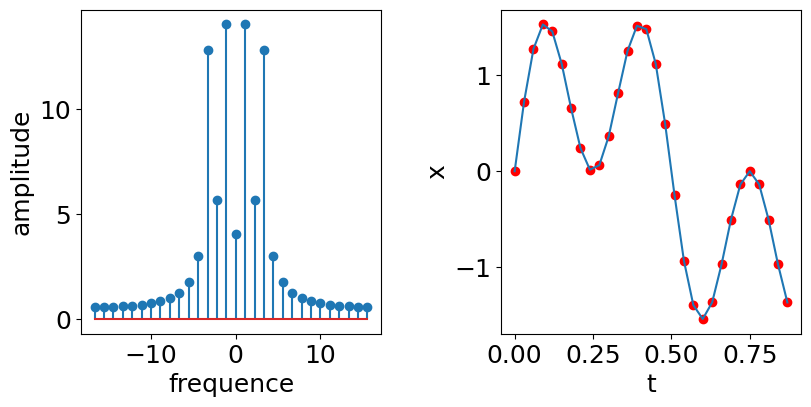

In [10]:
print('sample size=100: ')
dft_analysis(f, 1, 30)
print('sample size=10: ')
dft_analysis(f, 0.5, 30)
print('sample size=10: ')
dft_analysis(f, 0.9, 30)

#   The storage path of the output file.

The storage path is mainly based on the current time.

In [11]:
def mkdirs(fn):  
    
    """
    Create directories if they don't exist.

    Args:
    fn: The directory path to create.
    """

    if not os.path.isdir(fn):
        os.makedirs(fn)


def create_save_dir(path_ini):
    """
    Create a new directory with the current date and time as its name and return the path of the new directory.

    Args:
    path_ini: The initial path to create the new directory.

    Return:
    The path of the new directory.
    """
    subFolderName = re.sub(r'[^0-9]', '', str(datetime.datetime.now()))
    path = os.path.join(path_ini, subFolderName)
    mkdirs(path)
    mkdirs(os.path.join(path, 'output'))
    return path


args.path = create_save_dir(args.ini_path)
print('save path: %s' % (args.path))


save path: 20231016090854212246


# Generation of training and test sets.

Target function: $f(x)=sin(x)+sin(3x)+sin(5x)$

Training data interval: $[-\pi, \pi]$

Test data interval: $[-\pi-0.5, \pi+0.5]$

torch.Size([1000, 1])
torch.Size([101, 1])
The target function:


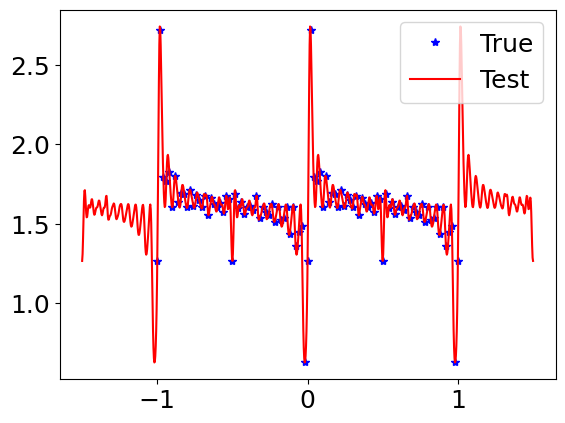

In [12]:
def get_y(x):  

    """
    Function to fit.

    Args:
        x (float): input value.

    Returns:
        float: output value.
    """
    print(x.shape)
    y = np.sin(x)+np.sin(3*x)+np.sin(5*x)
    y_hard=u(x,0.2,20)
    return y_hard


def u(x, y, N):
    result = 0
    for m in range(1, N+1):
        for n in range(1, N+1):
            term = np.exp(np.sin(2 * np.pi * m * x)) * np.exp(np.cos(2 * np.pi * n * y))
            result += term
    result /= (N ** 2)
    return result



for i in range(2):
    if isinstance(args.boundary[i], str):
        args.boundary[i] = eval(args.boundary[i])

args.test_input = torch.reshape(torch.linspace(args.boundary[0] - 0.5, args.boundary[1] + 0.5, steps=args.test_size), [args.test_size, 1])


args.training_input = torch.reshape(torch.linspace(args.boundary[0], args.boundary[1], steps=args.training_size), [args.training_size, 1])
args.test_target = get_y(args.test_input)
args.training_target = get_y(args.training_input)





def plot_target(args):

    """
    Plot the target.

    Args:
        args (object): object containing training and test input and target.

    """

    plt.figure()
    ax = plt.gca()

    plt.plot(args.training_input.detach().cpu().numpy(),
             args.training_target.detach().cpu().numpy(), 'b*', label='True')
    plt.plot(args.test_input.detach().cpu().numpy(),
             args.test_target.detach().cpu().numpy(), 'r-', label='Test')

    ax.tick_params(labelsize=18)
    plt.legend(fontsize=18)
    plt.show()

print("The target function:")
plot_target(args)



# Activation Functions

We mainly give four activation functions: Tanh, ReLU, Sigmoid, Hat.

Tanh function：

$$f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

ReLU function：

$$f(x) = \max(0, x)$$

Sigmoid function：

$$f(x) = \frac{1}{1 + e^{-x}}$$

Hat function：

$$f(x) = \begin{cases} x, & 0 \leq x < 1 \\  2 - x, & 1 \leq x < 2 \\ 0, & \text{otherwise}  \end{cases}$$



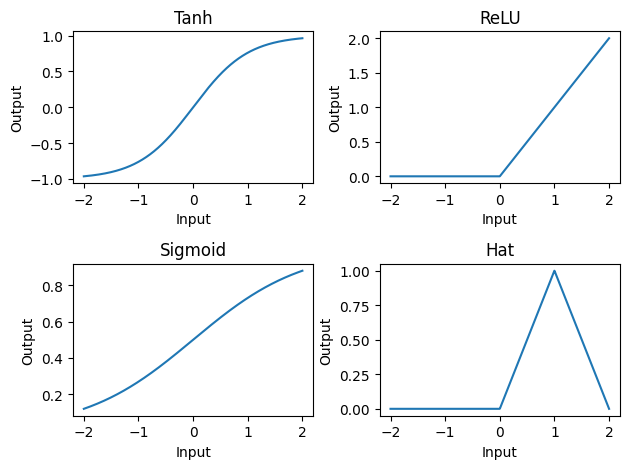

In [13]:

# Define the activation functions
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def hat(x):
    return np.piecewise(x, [np.logical_and(0 <= x, x < 1), np.logical_and(1 <= x, x < 2), x >= 2], [lambda x: x, lambda x: 2 - x, 0])

# Define the input range
x = np.linspace(-2, 2, 1000)

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2)

# Plot the activation functions in the subplots
axs[0, 0].plot(x, tanh(x))
axs[0, 0].set_title('Tanh')

axs[0, 1].plot(x, relu(x))
axs[0, 1].set_title('ReLU')

axs[1, 0].plot(x, sigmoid(x))
axs[1, 0].set_title('Sigmoid')

axs[1, 1].plot(x, hat(x))
axs[1, 1].set_title('Hat')

# Add labels to the subplots
for ax in axs.flat:
    ax.set(xlabel='Input', ylabel='Output')

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()
plt.close()

# Network model and parameter initialization.

Given $\theta\in \mathbb{R}^M$, the FNN function $f_{\theta}(\cdot)$ is defined recursively. First, we denote $f^{[0]}_{\theta}(x)=x$ for all $x\in\mathbb{R}^d$. Then, for $l\in[L-1]$, $f^{[l]}_{\theta}$ is defined recursively as 
$f^{[l]}_{\theta}(x)=\sigma (W^{[l]} f^{[l-1]}_{\theta}(x)+b^{[l]})$, where $\sigma$ is a non-linear activation function.
Finally, we denote
\begin{equation*}
    f_{\theta}(x)=f(x,\theta)=f^{[L]}_{\theta}(x)=W^{[L]} f^{[L-1]}_{\theta}(x)+b^{[L]}.
\end{equation*}

The parameter initialization is under the Gaussian distribution as follows,

\begin{equation*}
    \theta|_{l} \sim N(0, \frac{1}{m_{l}^t}),
\end{equation*}
where the $l$ th layer parameters of $\theta$ is the ordered pair $\theta|_{l}=\Big(W^{[l]},b^{[l]}\Big),\quad l\in[L]$, $m_{l}$ is the width of the $l$ th layer.

In [53]:
class Linear(nn.Module):
    def __init__(self, t, hidden_layers_width=[100],  input_size=20, num_classes: int = 1000, act_layer: nn.Module = nn.ReLU()):
        super(Linear, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_layers_width = hidden_layers_width
        self.t = t
        layers: List[nn.Module] = []
        self.layers_width = [self.input_size]+self.hidden_layers_width
        for i in range(len(self.layers_width)-1):
            layers += [nn.Linear(self.layers_width[i],
                                    self.layers_width[i+1]), act_layer]
        layers += [nn.Linear(self.layers_width[-1], num_classes)]
        self.features = nn.Sequential(*layers)
        self._initialize_weights()


    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.features(x)
        return x

    def _initialize_weights(self) -> None:

        for obj in self.modules():
            if isinstance(obj, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(obj.weight.data, 0, 1 /
                                self.hidden_layers_width[0]**(self.t))
                if obj.bias is not None:
                    nn.init.normal_(obj.bias.data, 0, 1 /
                                    self.hidden_layers_width[0]**(self.t))

class hat_torch(nn.Module):  # Custom activation function
    def __init__(self):
        super(hat_torch, self).__init__()

    def forward(self, x):
        y = torch.where((x > 0) & (x < 1), x,  torch.tensor(0.0))
        y = torch.where((x >= 1) & (x < 2), 2 - x, y)
        return y
    
class learn_psi_torch(nn.Module):  # Custom activation function
    def __init__(self):
        super(learn_psi_torch, self).__init__()
        # register parameter
        self.alpha = nn.Parameter(torch.tensor(1.0))  # 可学习的参数

        self.beta = nn.Parameter(torch.tensor(2.0))  # 可学习的参数

        self.gamma = nn.Parameter(torch.tensor(3.0))  # 可学习的参数

        self.coff = nn.Parameter(torch.tensor([1.0,-3.0,3.0,-1.0]))  # 可学习的参数


    def forward(self, x):

        return (
                self.coff[0]*F.relu(x - 0) ** 2
                +self.coff[1] * F.relu(x -  self.alpha) ** 2
                + self.coff[2] * F.relu(x - self.beta) ** 2
                +self.coff[3] *F.relu(x -  self.gamma) ** 2
        )


def get_act_func(act_func):

    """
    Get activation function.

    Args:
        act_func (str): activation function name.

    Returns:
        nn.Module: activation function.
    """

    if act_func == 'tanh':
        return nn.Tanh()
    elif act_func == 'ReLU':
        return nn.ReLU()
    elif act_func == 'Sigmoid':
        return nn.Sigmoid()
    elif act_func == 'hat':
        return hat_torch()
    elif act_func =="learn_psi":
        return learn_psi_torch() 
    else:
        raise NameError('No such act func!')


act_func = get_act_func(args.act_func_name)

model = Linear(args.t, args.hidden_layers_width, args.input_dim,
               args.output_dim, act_func).to(args.device)
print("The network structure:")
print(model)


The network structure:
Linear(
  (features): Sequential(
    (0): Linear(in_features=1, out_features=200, bias=True)
    (1): learn_psi_torch()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): learn_psi_torch()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): learn_psi_torch()
    (6): Linear(in_features=200, out_features=100, bias=True)
    (7): learn_psi_torch()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)



\begin{equation*}
    \theta_{t+1}=\theta_t-\eta\nabla R_S(\theta).
\end{equation*}

In [54]:
def train_one_step(model, optimizer, loss_fn,  args):

    """
    Train one step.

    Args:
        model (nn.Module): model.
        optimizer (optim.Optimizer): optimizer.
        loss_fn (nn.Module): loss function.
        args (object): object containing training and test input and target.

    Returns:
        tuple: tuple containing loss and outputs.
    """

    # Set the model to training mode (Dropout, BN, etc.)
    model.train()

    # Get the device to use for computation
    device = args.device

    training_loss = 0.0
    total = 0

    # Move the training input and target to the device and convert the target to float
    data, target = args.training_input.to(device), args.training_target.to(device).to(torch.float)

    # Loop over the training data in batches
    for i in range(args.training_size // args.batch_size ):  

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Randomly select a batch of data
        mask = np.random.choice(args.training_size, args.batch_size, replace=False)

        # Get the model's predictions for the selected data
        y_train = model(data[mask])

        # Calculate the loss between the predictions and the target
        loss = loss_fn(y_train, target[mask])

        # Compute the gradients of the loss with respect to the model parameters
        loss.backward()

        #loss.grad.data

        # Update the model parameters using the optimizer
        optimizer.step()

        training_loss+=loss.item()*args.batch_size
        total += args.batch_size

    # Get the model's predictions for all the training data
    outputs = model(data)

    return training_loss/total, outputs


# One-step test function.

In [55]:
def test(model, loss_fn, args):
    """
    Test.

    Args:
        model (nn.Module): model.
        loss_fn (nn.Module): loss function.
        args (object): object containing training and test input and target.

    Returns:
        tuple: tuple containing loss and outputs.
    """

    model.eval()
    device = args.device
    with torch.no_grad():
        data, target = args.test_input.to(
            device), args.test_target.to(device).to(torch.float)
        outputs = model(data)
        loss = loss_fn(outputs, target)

    return loss.item(), outputs


# Plot the loss value.

In [56]:
def plot_loss(path, loss_train, x_log=False):

    """
    Plot loss.

    Args:
        path (str): path.
        loss_train (list): list of training loss.
        x_log (bool): whether to use log scale for x-axis.

    Returns:
        None.
    """
    plt.figure()
    ax = plt.gca()
    y2 = np.asarray(loss_train)
    plt.plot(y2, 'k-', label='Train')
    plt.xlabel('epoch', fontsize=18)
    ax.tick_params(labelsize=18)
    plt.yscale('log')
    if x_log == False:
        fntmp = os.path.join(path, 'loss.png')

    else:
        plt.xscale('log')
        fntmp = os.path.join(path, 'loss_log.png')
    plt.tight_layout()
    plt.savefig(fntmp,dpi=300)


    plt.close()


# Plot the output figure.



In [57]:
def plot_model_output(path, args, output, epoch):

    plt.figure()
    ax = plt.gca()

    plt.plot(args.training_input.detach().cpu().numpy(),
             args.training_target.detach().cpu().numpy(), 'b*', label='True')
    plt.plot(args.test_input.detach().cpu().numpy(),
             output.detach().cpu().numpy(), 'r-', label='Test')

    ax.tick_params(labelsize=18)
    plt.legend(fontsize=18)
    fntmp = os.path.join(path, 'output', str(epoch)+'.png')

    plt.savefig(fntmp, dpi=300)


    plt.close()


# Training Process

In [58]:
if args.optimizer=='sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
loss_fn = nn.MSELoss(reduction='mean')
t0 = time.time()
args.loss_training_lst=[]
args.loss_test_lst = []
args.training_output=[]
for epoch in range(args.epochs+1):

      model.train()
      loss, training_output = train_one_step(
        model, optimizer, loss_fn, args)
      loss_test, output = test(
          model, loss_fn, args)
      args.loss_training_lst.append(loss)
      args.loss_test_lst.append(loss_test)
      args.training_output.append(training_output.detach().cpu().numpy())
      if epoch % args.plot_epoch == 0:
            print("[%d] loss: %.6f valloss: %.6f time: %.2f s" %
                  (epoch + 1, loss, loss_test, (time.time()-t0)))
  
      if (epoch+1) % (args.plot_epoch) == 0:
          plot_loss(path=args.path,
                    loss_train=args.loss_training_lst, x_log=True)
          plot_loss(path=args.path,
                    loss_train=args.loss_training_lst, x_log=False)

          plot_model_output(args.path, args, output, epoch)




[1] loss: 2.603710 valloss: 2.609454 time: 0.06 s
[1001] loss: 0.047804 valloss: 0.178230 time: 29.44 s
[2001] loss: 0.045341 valloss: 0.188888 time: 57.91 s
[3001] loss: 0.044758 valloss: 0.157715 time: 86.44 s
[4001] loss: 0.043917 valloss: 0.280757 time: 114.50 s
[5001] loss: 0.042514 valloss: 0.141744 time: 142.84 s
[6001] loss: 0.034837 valloss: 5.889316 time: 171.00 s
[7001] loss: 0.029808 valloss: 40.167721 time: 199.41 s
[8001] loss: 0.028411 valloss: 68.467438 time: 227.58 s
[9001] loss: 0.027914 valloss: 89.345551 time: 256.05 s
[10001] loss: 0.027236 valloss: 94.644913 time: 284.05 s
[11001] loss: 0.026874 valloss: 85.052414 time: 312.81 s
[12001] loss: 0.026566 valloss: 83.169975 time: 342.23 s
[13001] loss: 0.026226 valloss: 81.113785 time: 370.83 s
[14001] loss: 0.025859 valloss: 80.128471 time: 398.78 s
[15001] loss: 0.025478 valloss: 78.816177 time: 428.10 s
[16001] loss: 0.025058 valloss: 77.497742 time: 457.00 s
[17001] loss: 0.024558 valloss: 77.675217 time: 485.63 s

# Plot the frequency distribution figure

To avoid the interference of amplitude on the experiment, we study the changes in relative error at different frequencies. We consider the following quantities:
$$
\Delta_F(k)=\frac{\left|\hat{h}_k-\hat{f}_k\right|} {\left|\hat{f}_k\right|}
$$

where $\hat{h}_k$ and $\hat{f}_k$ are the discrete Fourier transform (DFT) of the DNN output $h(x)$ and the  target function $f(x)$,  $|·|$ denotes the norm of a complex number.

In [62]:
def plot_freq_distr(args):

    """
    Plot frequency distribution and the heatmap of the given training target and output.
    
    Args:
    args: A dictionary containing training target and output.
    
    Returns:
    None
    """
    y_fft = my_fft(args.training_target.detach().cpu().numpy()) / \
        args.training_size
    plt.figure()
    ax = plt.gca()
    plt.semilogy(y_fft+1e-5, label='Target')
    idx = SelectPeakIndex(y_fft, endpoint=False)
    plt.semilogy(idx, y_fft[idx]+1e-5, 'o')
    y_fft_pred = my_fft(args.training_output[-1])/args.training_size
    plt.semilogy(y_fft_pred+1e-5, label='Model output')
    plt.semilogy(idx, y_fft_pred[idx]+1e-5, 'o')
    plt.legend(fontsize=22)
    plt.xlabel('freq idx', fontsize=22)
    plt.ylabel('freq', fontsize=22)
    plt.gca().tick_params(axis='y', labelsize=22)
    plt.gca().tick_params(axis='x', labelsize=22)
    plt.tight_layout()
    plt.savefig(os.path.join(args.path, 'fft.png'), dpi=300)
    plt.show()
    plt.close()

    y_pred_epoch = np.squeeze(args.training_output)
    idx1 = idx[:3]
    abs_err = np.zeros([len(idx1), len(args.training_output)])
    y_fft = my_fft(args.training_target)
    tmp1 = y_fft[idx1]
    print(abs_err.shape)
    for i in range(len(y_pred_epoch)):
        tmp2 = my_fft(y_pred_epoch[i])[idx1]
        abs_err[:, i] = np.abs(tmp1 - tmp2)/(1e-5 + tmp1)

    

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    plt.pcolor(abs_err, cmap='RdBu', vmin=0.1, vmax=1, linewidths=0.4)
    plt.colorbar()

   
    plt.xlabel('Epoch', fontsize=22)

    # Set the y-axis ticks and labels to 1, 2, 3, and rotate the labels
    plt.yticks([0.5, 1.5, 2.5], [1, 2, 3], rotation=0, fontsize=22)

    # Set the y-axis tick parameters to hide the tick marks and set the tick label size
    plt.gca().yaxis.set_tick_params(size=0)
    plt.gca().tick_params(axis='y', labelsize=22)
    plt.gca().tick_params(axis='x', labelsize=22)


    plt.title('Absolute Error', fontsize=22)

    plt.tight_layout()

    plt.savefig(os.path.join(args.path, 'hot.png'))
    plt.show()
    plt.close()


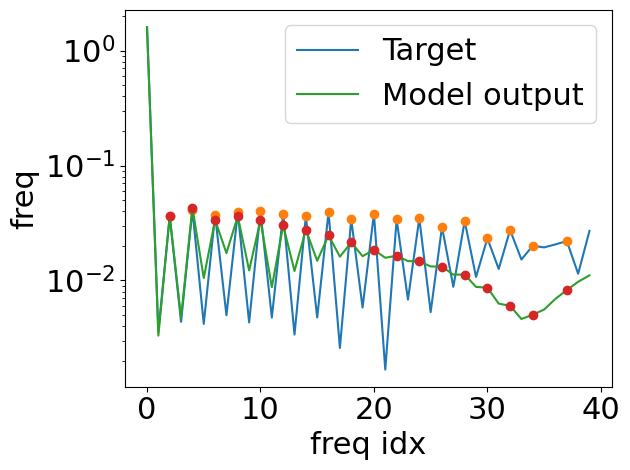

(3, 20001)


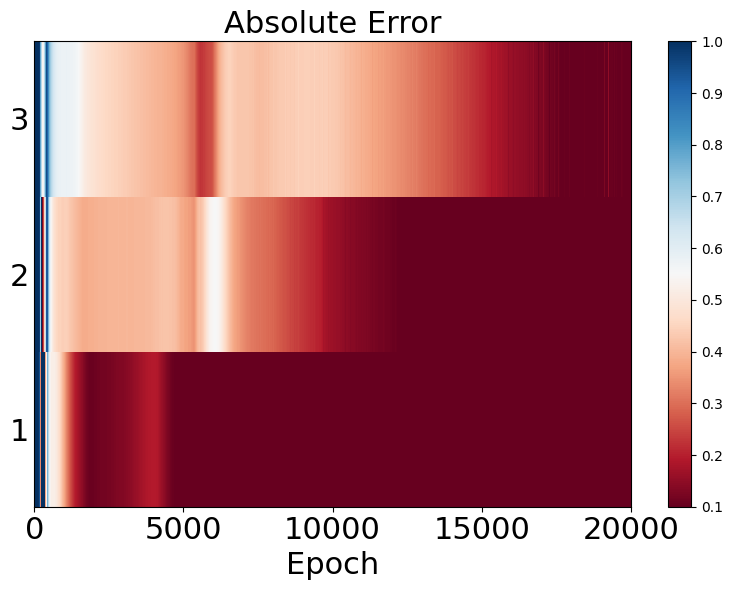

In [63]:
plot_freq_distr(args)

# Task

1. Change the horizontal axis of the relative error to a log scale to better observe the changes in low-frequency relative error in the initial stage. 

2. Try different objective functions, domains, and activation functions to verify the frequency principle. 

3. Study how different frequency amplitudes affect the convergence speed of the model. Taking the objective function $sin(x)+a*sin(5x)$ as an example, where $a$ is a given parameter. We can plot the horizontal axis as $a$ and the vertical axis as (the number of steps required for high-frequency relative error <10%) / (the number of steps required for low-frequency relative error <10%) under this objective function.

# Code generated by New Bing 

prompt1: 帮我构造一个神经网络拟合目标函数的例子，目标函数是$sin(x)+a*sin(5x)$。我们假设a为[0.5,2]中的linspace采样，对于不同的a，我们均训练8000步，并记录每一步神经网络的输出，并保存到以a为key的字典中，每个key对应的值是一个列表，这个列表记录了每10步网络的输出值。神经网络的结构为五层神经网络，宽度为256,以Tanh作为激活函数. 我们使用full batch的Adam进行训练，学习率为1e-4. 对于input data，我们希望它是在[-pi, pi]上的linspace采样。你需要注意，模型的input与output应该具有相同的size。

In [18]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 1)
        self._initialize_weights()

    def _initialize_weights(self) -> None:

        for obj in self.modules():
            if isinstance(obj, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(obj.weight.data, 0, 1 /
                                128)
                if obj.bias is not None:
                    nn.init.normal_(obj.bias.data, 0, 1 /
                                    128)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        return x
    


def train(a):
    net = Net()
    optimizer = Adam(net.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    x = np.linspace(-np.pi, np.pi, 1000).reshape(-1, 1)
    y = np.sin(x) + a * np.sin(5 * x)
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    res_dict = {}
    res_list = []
    for i in range(4000):
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        # if i % 10 == 0:
        res_list.append(y_pred.detach().numpy())
        if i % 1000 == 0:
            print(f'a={a:.2f}, Step {i}: Loss = {loss.item():.4f}')
    res_dict[a] = res_list
    return res_dict


a_list = np.linspace(1, 2.5, 20)
res_dict = {}
for a in a_list:
    res_dict.update(train(a))



a=1.00, Step 0: Loss = 0.9991
a=1.00, Step 1000: Loss = 0.3923
a=1.00, Step 2000: Loss = 0.1742
a=1.00, Step 3000: Loss = 0.0294
a=1.08, Step 0: Loss = 1.0811
a=1.08, Step 1000: Loss = 0.4528
a=1.08, Step 2000: Loss = 0.1707
a=1.08, Step 3000: Loss = 0.0304
a=1.16, Step 0: Loss = 1.1692
a=1.16, Step 1000: Loss = 0.5185
a=1.16, Step 2000: Loss = 0.0798
a=1.16, Step 3000: Loss = 0.0342
a=1.24, Step 0: Loss = 1.2636
a=1.24, Step 1000: Loss = 0.5891
a=1.24, Step 2000: Loss = 0.1073
a=1.24, Step 3000: Loss = 0.0369
a=1.32, Step 0: Loss = 1.3643
a=1.32, Step 1000: Loss = 0.6653
a=1.32, Step 2000: Loss = 0.0617
a=1.32, Step 3000: Loss = 0.0397
a=1.39, Step 0: Loss = 1.4714
a=1.39, Step 1000: Loss = 0.7438
a=1.39, Step 2000: Loss = 0.1324
a=1.39, Step 3000: Loss = 0.0436
a=1.47, Step 0: Loss = 1.5843
a=1.47, Step 1000: Loss = 0.8274
a=1.47, Step 2000: Loss = 0.0671
a=1.47, Step 3000: Loss = 0.0487
a=1.55, Step 0: Loss = 1.7036
a=1.55, Step 1000: Loss = 0.9232
a=1.55, Step 2000: Loss = 0.1149
a

Prompt2: 在上面这个代码中，我们获得了res_dict，包含每一个$a$对应的目标函数在训练过程中的输出。我们的目标函数是sin（x）+a*sin(5x), 现在我希望对每个a，计算模型每步训练时，在频率为1和频率为5处模型的输出与目标函数在傅里叶空间的相对误差。也就是对训练的每一步，对模型输出及目标函数进行傅里叶变换，取他们频率为1的模长，求相对误差，再取他们频率为5的模长，求相对误差。

In [19]:
from numpy.fft import fft

error_1_list_all=[]
error_5_list_all=[]

def calc_relative_error(res_dict, a):
    x = np.linspace(-np.pi, np.pi, 1000).reshape(-1, 1)
    y = np.sin(x) + a * np.sin(5 * x)
    y_fft = fft(y.squeeze())
    error_1_list = []
    error_5_list = []
    for y_pred in res_dict[a]:
        y_pred_fft = fft(y_pred.squeeze())
        error_1 = abs(abs(y_fft[1]) - abs(y_pred_fft[1])) / abs(y_fft[1])
        error_5 = abs(abs(y_fft[5]) - abs(y_pred_fft[5])) / abs(y_fft[5])
        error_1_list.append(error_1)
        error_5_list.append(error_5)
    return error_1_list, error_5_list


for a in a_list:
    error_1_list, error_5_list = calc_relative_error(res_dict, a)
    error_1_list_all.append(error_1_list)
    error_5_list_all.append(error_5_list)   
    # print(f'For a={a}, the relative errors at frequency 1 are {error_1_list}, the relative errors at frequency 5 are {error_5_list}')



Prompt3: 假设对于a_list中的每个a，我们都得到了error_1_list和error_5_list，并把它们保存在列表error_1_list_all及error_5_list_all中，现在我们需要对每个a，找出其对应的error_1_list和error_5_list中error首次小于0.1的error的index，记为error_1_index及error_5_index，对于不同的a，我们都可以计算error_1_index/error_5_index的值。最后我们绘制一张横坐标为a，纵坐标为error_1_index/error_5_index的图像。

[66, 65, 66, 65, 65, 65, 65, 64, 64, 64, 64, 65, 64, 64, 65, 64, 63, 64, 64, 64] [2919, 2271, 2177, 2133, 2020, 2039, 1998, 2024, 1976, 1931, 1862, 1867, 1843, 1841, 1828, 1769, 1862, 1906, 1908, 1972]


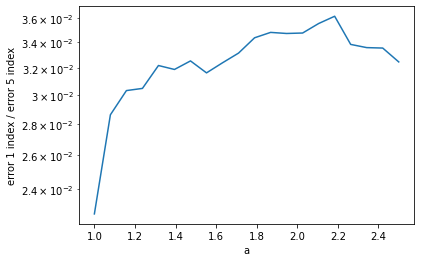

In [58]:


def calc_error_index(error_1_list_all, error_5_list_all):
    error_1_index_list = []
    error_5_index_list = []
    for error_1_list, error_5_list in zip(error_1_list_all, error_5_list_all):

        error_1_index = np.where(np.array(error_1_list) < 0.1)[0][0]
        error_5_index = np.where(np.array(error_5_list) < 0.1)[0][0]
        error_1_index_list.append(error_1_index)
        error_5_index_list.append(error_5_index)


    return error_1_index_list, error_5_index_list



error_1_list_all = []
error_5_list_all = []
for a in a_list:
    error_1_list, error_5_list = calc_relative_error(res_dict, a)
    error_1_list_all.append(error_1_list)
    error_5_list_all.append(error_5_list)

error_1_index_list, error_5_index_list = calc_error_index(error_1_list_all, error_5_list_all)

ratio = np.array(error_1_index_list) / np.array(error_5_index_list)
plt.plot(a_list, ratio)
plt.xlabel('a')
plt.yscale('log')
plt.ylabel('error 1 index / error 5 index')
plt.show()
